In [1]:
import time
import pandas as pd
import numpy as np

# For plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', palette='deep')

## Gathering Data

Strava has a publicly available API interface that allows developers to access Strava data. Mandie Quartly has wrote an excellent guide on how to grab your Strava data using Stravas API V3, this guide can be found [here](https://medium.com/@mandieq). The csv file that is read in the following section was retrieved using this guide.



## Data Exploration

The head() function returns the first $n$ rows, which is by default 5 (using zero-based numbering, the initial element of a sequence is assigned the index 0, rather than the index 1). This is useful when checking that the dataframe is holding the data of interest, in a format we understand.

In [2]:
df = pd.read_csv("activities.csv")
df.head()

,Unnamed: 0,id,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,start_latitude,start_longitude,flagged,distance_km,day_of_week,month_of_year
0,0,4270212916,2020-11-01 10:41:51,Run,6257.7,0 days 00:33:03.000000000,0 days 00:34:56.000000000,12.2,40.9,26.7,3.156,5.3,41.960250,3.038900,False,6.2577,Sunday,11
1,1,4261801695,2020-10-30 12:11:15,Run,6509.1,0 days 00:32:31.000000000,0 days 00:32:31.000000000,12.1,40.1,26.7,3.336,7.0,41.960362,3.039066,False,6.5091,Friday,10
2,2,4258427984,2020-10-29 14:34:26,Run,1313.1,0 days 00:07:04.000000000,0 days 00:07:04.000000000,5.9,39.5,33.3,3.097,9.1,41.970032,3.033507,False,1.3131,Thursday,10
3,3,4258403656,2020-10-29 14:03:07,Run,6466.1,0 days 00:30:34.000000000,0 days 00:30:34.000000000,7.0,40.1,26.3,3.526,5.0,41.960384,3.039412,False,6.4661,Thursday,10
4,4,4249784457,2020-10-27 13:49:43,Run,1275.3,0 days 00:07:17.000000000,0 days 00:07:28.000000000,5.8,40.0,33.8,2.918,4.5,41.969520,3.033521,False,1.2753,Tuesday,10


The .dtypes function returns the name of each feature along with the respective data type. This is useful in order to quickly observe if the data needs to be cleaned from undesirable samples.

In [3]:
df.dtypes

Unnamed: 0                int64
id                        int64
start_date_local         object
type                     object
distance                float64
moving_time              object
elapsed_time             object
total_elevation_gain    float64
elev_high               float64
elev_low                float64
average_speed           float64
max_speed               float64
start_latitude          float64
start_longitude         float64
flagged                    bool
distance_km             float64
day_of_week              object
month_of_year             int64
dtype: object

From the above output, one feature exists that is not desired. Flagged activities. Flagged activities in Strava are activities where some part of the sample data is not accurate. This is usually the GPS location data. The next line of code reports the number of activities that have a true or false value assigned to the flagged feature. 

In [4]:
df.flagged.value_counts()


False    676
True      16
Name: flagged, dtype: int64

There are 16 runs that have been flagged. The following finds any sample that has a flagged run that equals True, and then drops that row from the dataframe. Afterwards, the dataframe is checked again to ensure that no more flagged runs appear in the dataframe.

In [5]:
df.drop(df[df['flagged'] == True].index, inplace=True)
df.flagged.value_counts()

False    676
Name: flagged, dtype: int64

One useful way to visualise what activities are present in the dataframe, and the frequency of each activity, is the sns.catplot() function. A catplot of kind='count' is just a histogram across a categorical variable.

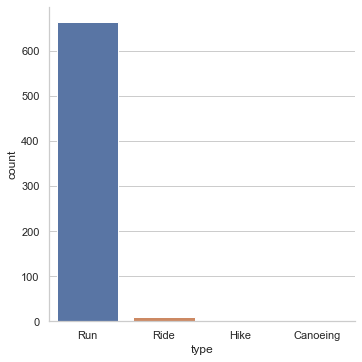

In [6]:
sns.catplot(x='type', kind='count', data=df)

Another useful way to check what activities are present is by using the value_counts() function. This function returns a Series containing counts of unique values. This project is only interested in running. Therefore the next job is to check if any other activities exist, and if so, drop them from the dataframe. 

In [7]:
df.type.value_counts()

Run         664
Ride         10
Hike          1
Canoeing      1
Name: type, dtype: int64

The above output reports 664 runs, 10 bike rides, 1 canoeing session, and 1 hike. This is also visualised using the displayed plot. Because this project is only interested in running, all but running will now be dropped from the datframe.

In [8]:
df.drop(df[df['type'].isin(['Run']) != True].index, inplace=True)
df.type.value_counts()

Run    664
Name: type, dtype: int64

Now that the activity of interest is isolated, some of the feature data types can be converted into types that are simpler to work with. Besides this, distance is converted from kilometers to miles, and speed is converted from meters per second into minute per mile. Although not SI Units, the mile, and minute per mile are common units used by running athletes to measure performance. A year column is also created so that the data can later be visualised based upon years, which can be useful.

In [9]:
# Create a distance in miles column
conv_fac_kilometers_miles = 0.621371 # conversion factor
df['distance_miles'] = (df['distance']*conv_fac_kilometers_miles)/1e3

# Convert m/s to min/mi
df['minute_mile'] = 1/(df['average_speed']/26.822)

# Convert dates to datetime type
df['start_date_local'] = pd.to_datetime(df['start_date_local'])

# Create a day of the week and week of the year columns
df['day_of_week'] = df['start_date_local'].dt.day_name()
df['month_of_year'] = df['start_date_local'].dt.month

# Convert times to timedeltas
df['moving_time'] = pd.to_timedelta(df['moving_time'])
df['elapsed_time'] = pd.to_timedelta(df['elapsed_time'])

# Convert start date to years
df['year'] = pd.DatetimeIndex(df['start_date_local']).year

df.head()

,Unnamed: 0,id,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,...,max_speed,start_latitude,start_longitude,flagged,distance_km,day_of_week,month_of_year,distance_miles,minute_mile,year
0,0,4270212916,2020-11-01 10:41:51,Run,6257.7,0 days 00:33:03,0 days 00:34:56,12.2,40.9,26.7,...,5.3,41.960250,3.038900,False,6.2577,Sunday,11,3.888353,8.498733,2020
1,1,4261801695,2020-10-30 12:11:15,Run,6509.1,0 days 00:32:31,0 days 00:32:31,12.1,40.1,26.7,...,7.0,41.960362,3.039066,False,6.5091,Friday,10,4.044566,8.040168,2020
2,2,4258427984,2020-10-29 14:34:26,Run,1313.1,0 days 00:07:04,0 days 00:07:04,5.9,39.5,33.3,...,9.1,41.970032,3.033507,False,1.3131,Thursday,10,0.815922,8.660639,2020
3,3,4258403656,2020-10-29 14:03:07,Run,6466.1,0 days 00:30:34,0 days 00:30:34,7.0,40.1,26.3,...,5.0,41.960384,3.039412,False,6.4661,Thursday,10,4.017847,7.606920,2020
4,4,4249784457,2020-10-27 13:49:43,Run,1275.3,0 days 00:07:17,0 days 00:07:28,5.8,40.0,33.8,...,4.5,41.969520,3.033521,False,1.2753,Tuesday,10,0.792434,9.191912,2020


Next is a categorical plot of run frequency plotted against year.

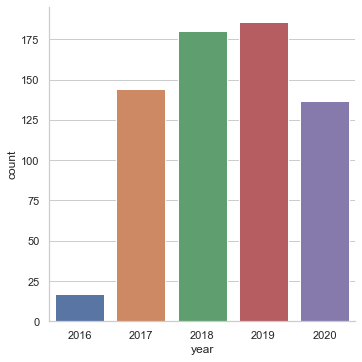

In [10]:
sns.catplot(x='year', kind='count', data=df)

Next the day of the week a run occurs is plotted against distance in miles. For this a Violin plot is used because it shows the full distribution of the data. In this example, the density of the distance run per day as well as the min and max distance run.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

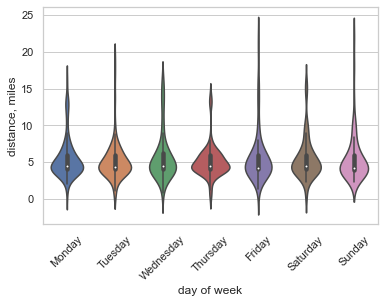

In [11]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]

ax = sns.violinplot(x='day_of_week', y='distance_miles', data=df, order=days_of_week)
ax.set(xlabel="day of week", ylabel = "distance, miles")
plt.xticks(rotation=45)

[Text(0.5, 0, 'distance, miles'), Text(0, 0.5, 'speed, minute mile')]

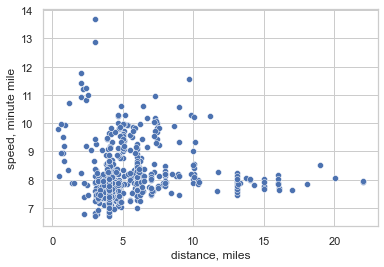

In [12]:
ax = sns.scatterplot(x='distance_miles', y='minute_mile', data=df)
ax.set(xlabel="distance, miles", ylabel = "speed, minute mile")

There is significant variation in average minute per mile pace on runs of 10 miles or less. For runs greater than 10 miles, the average minute per mile pace is significantly less varied.

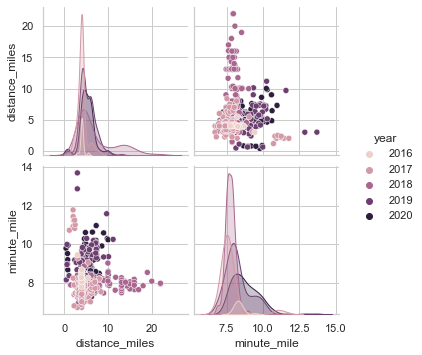

In [13]:
sns.pairplot(df,vars = ['distance_miles', 'minute_mile'], hue='year')